In [1]:
from qutip import *
import numpy as np
import sympy as sp
from qiskit import QuantumCircuit

rho_0 = Qobj([[1,0],[0,0]])
rho_1 = Qobj([[0,0],[0,1]])

I =  qeye(2)
X = sigmax()
Y = sigmay()
Z = sigmaz()
H = 1/np.sqrt(2)*Qobj([[1,1],[1,-1]])

c = 1/np.sqrt(1)

r = c*np.array([0.5,0,0])       #[rx,ry,rz]

rho_a = 1/2*(I+r[0]*X + r[1]*Y + r[2]*Z)
# rho_a = Qobj([[0,0],[0,1]])

rho = tensor(rho_a,rho_0,rho_0)
rho_a


Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.5  0.25]
 [0.25 0.5 ]]

In [2]:
def some(n=3, name='xh'):
    qc = QuantumCircuit(n, name=name)
    qc.x(0)
    qc.x(0)
    return qc

U_gate = some().to_gate()
U_gate.label = "Error"


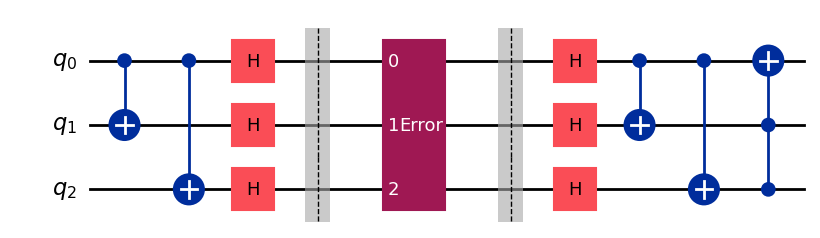

In [4]:
qc = QuantumCircuit(3)

qc.cx(0,1)
qc.cx(0,2)

qc.h([0,1,2])
qc.barrier()
qc.append(U_gate,[0,1,2])
qc.barrier()

qc.h([0,1,2])
qc.cx(0,1)
qc.cx(0,2)
qc.ccx(1,2,0)

qc.draw('mpl')

In [2]:
p = 0.5
K_0 = np.sqrt(p)*sp.kronecker_product(Z,I,I)
K_1 = np.sqrt(1-p)*tensor(I,I,I)


In [3]:

U_1 = tensor(rho_0,I,I) + tensor(rho_1,X,I)
U_2 = tensor(rho_0,I,I) + tensor(rho_1,I,X)
U_4 = U_1
U_5 = U_2
U_6 = tensor(I,rho_0,rho_0) + tensor(I,rho_0,rho_1) + tensor(I,rho_1,rho_0) + tensor(X,rho_1,rho_1)
rho_H = tensor(H,H,H)

In [4]:
# U = U_6*U_5*U_4*rho_H*K_0*rho_H*U_2*U_1

Ua = U_6@U_5@U_4@rho_H@K_0@rho_H@U_2@U_1
Ub = U_6@U_5@U_4@rho_H@K_1@rho_H@U_2@U_1

In [5]:
final = Ub@rho@Ub.trans() + Ua@rho@Ua.trans()
# final
# d

In [6]:
reduced_rho = final.ptrace(0)
reduced_rho

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.5  0.25]
 [0.25 0.5 ]]

In [7]:
rho_a

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.5  0.25]
 [0.25 0.5 ]]

In [8]:
fidelity(rho_a,reduced_rho)

0.9999999999999993

We get the original matrix rho back after error correction

In [37]:

# @njit
def phaseflip(x,y,z,p):

    rho_0 = Qobj([[1,0],[0,0]])
    rho_1 = Qobj([[0,0],[0,1]])

    I =  qeye(2)
    X = sigmax()
    Y = sigmay()
    Z = sigmaz()
    H = 1/np.sqrt(2)*Qobj([[1,1],[1,-1]])
    
    rho_initial = 1/2*(I+x*X + y*Y + z*Z)
    # rho_a = Qobj([[0,0],[0,1]])

    rho = tensor(rho_initial,rho_0,rho_0)

    #Defining the Kraus operators corresponding to the error
    K_0 = np.sqrt(p)*tensor(Z,Z,Z)
    K_1 = np.sqrt(1-p)*tensor(I,I,I)

    #defining the gates corresponding to the bit flip circuit
    U_1 = tensor(rho_0,I,I) + tensor(rho_1,X,I)
    U_2 = tensor(rho_0,I,I) + tensor(rho_1,I,X)
    U_4 = U_1
    U_5 = U_2
    U_6 = tensor(I,rho_0,rho_0) + tensor(I,rho_0,rho_1) + tensor(I,rho_1,rho_0) + tensor(X,rho_1,rho_1)

    Ua = U_6@U_5@U_4@rho_H@K_0@rho_H@U_2@U_1
    Ub = U_6@U_5@U_4@rho_H@K_1@rho_H@U_2@U_1

    final = Ub@rho@Ub.trans() + Ua@rho@Ua.trans()
    reduced_rho = final.ptrace(0)

    ans = fidelity(rho_initial,reduced_rho)
    return  ans

In [38]:
# @njit
def generate_fidelity_data(phaseflip, step):
    # Initialize an empty list to store the results
    fidelity_data = []

    # Iterate over values of x, y, z
    for x in np.arange(-1, 1 + step, step):
        for y in np.arange(-1, 1 + step, step):
            for z in np.arange(-1, 1 + step, step):
                # Check if the point (x, y, z) is within the Bloch sphere
                if x**2 + y**2 + z**2 <= 1:
                    # Iterate over values of p from 0 to 1 with step size
                    for p in np.arange(0, 1 + step, step):
                        # Compute the fidelity for the given (x, y, z, p)
                        fidelity = phaseflip(x, y, z, p)
                        # Store the values and the computed fidelity
                        fidelity_data.append((x, y, z, p, fidelity))
    
    return fidelity_data

In [47]:
fidelity_results = generate_fidelity_data(phaseflip, 0.04)
# print(np.size(fidelity_results))

In [48]:
fidelity_data = np.array(fidelity_results)

# Extract the p values and fidelity values
p_values = fidelity_data[:, 3]
fidelity_values = fidelity_data[:, 4]

# Get the unique p values
unique_p_values = np.unique(p_values)


In [49]:
average_fidelity_by_p = {p: np.mean(fidelity_values[p_values == p]) for p in unique_p_values}

# Print the average fidelity for each distinct value of p
for p, avg_fidelity in average_fidelity_by_p.items():
    print(f"Average Fidelity for p={np.round(p,2)}: {np.round(avg_fidelity,3)}")

Average Fidelity for p=0.0: 1.0
Average Fidelity for p=0.04: 0.999
Average Fidelity for p=0.08: 0.996
Average Fidelity for p=0.12: 0.992
Average Fidelity for p=0.16: 0.988
Average Fidelity for p=0.2: 0.983
Average Fidelity for p=0.24: 0.978
Average Fidelity for p=0.28: 0.972
Average Fidelity for p=0.32: 0.965
Average Fidelity for p=0.36: 0.958
Average Fidelity for p=0.4: 0.951
Average Fidelity for p=0.44: 0.943
Average Fidelity for p=0.48: 0.934
Average Fidelity for p=0.52: 0.925
Average Fidelity for p=0.56: 0.916
Average Fidelity for p=0.6: 0.906
Average Fidelity for p=0.64: 0.895
Average Fidelity for p=0.68: 0.884
Average Fidelity for p=0.72: 0.872
Average Fidelity for p=0.76: 0.859
Average Fidelity for p=0.8: 0.845
Average Fidelity for p=0.84: 0.83
Average Fidelity for p=0.88: 0.814
Average Fidelity for p=0.92: 0.796
Average Fidelity for p=0.96: 0.776
Average Fidelity for p=1.0: 0.751


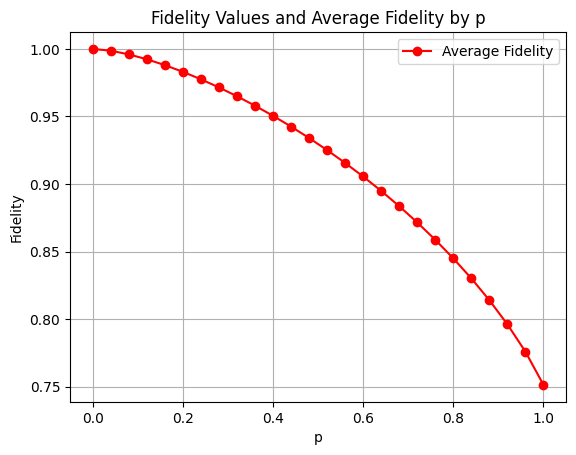

In [50]:
import matplotlib.pyplot as plt

# plt.scatter(p_values, fidelity_values, label='Fidelity Values', alpha=0.6)

# Plot the average fidelity for each p value
avg_p = np.array(list(average_fidelity_by_p.keys()))
avg_fidelity = np.array(list(average_fidelity_by_p.values()))
plt.plot(avg_p, avg_fidelity, color='red', label='Average Fidelity', marker='o')

# Add labels and title
plt.xlabel('p')
plt.ylabel('Fidelity')
plt.title('Fidelity Values and Average Fidelity by p')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()